# Categorical Encoding: Label, Ordinal, One-Hot, and Target

Machine learning models work with numbers. Categorical features — like `["low", "medium", "high"]` or `["cat", "dog", "fish"]` — must be converted into numeric form before a model can use them.

This notebook covers four common encoding strategies:

- **Label Encoding** — assigns an arbitrary integer to each category
- **Ordinal Encoding** — assigns integers based on a user-defined order
- **One-Hot Encoding** — creates a binary column for each category
- **Target Encoding** — replaces a category with the mean of the target variable

We use a custom synthetic dataset throughout so every number is traceable and transparent.

## 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

# reproducibility
np.random.seed(42)

print("Imports OK")

Imports OK


## 2. Build the Synthetic Dataset

We simulate a small customer dataset with:

- `education` — nominal-ish but we will treat as ordinal (clear rank exists)
- `city` — purely nominal (no natural rank)
- `satisfaction` — ordinal (low < medium < high)
- `spent` — continuous numeric target (how much the customer spent in dollars)

In [2]:
n = 200

education_levels = ["high_school", "bachelors", "masters", "phd"]
cities           = ["London", "Paris", "Berlin", "Tokyo", "Sydney"]
satisfaction     = ["low", "medium", "high"]

# assign integer codes for education so higher education -> higher spend on average
edu_code_map   = {"high_school": 0, "bachelors": 1, "masters": 2, "phd": 3}
sat_code_map   = {"low": 0, "medium": 1, "high": 2}

edu_col  = np.random.choice(education_levels, size=n, p=[0.3, 0.4, 0.2, 0.1])
city_col = np.random.choice(cities, size=n)
sat_col  = np.random.choice(satisfaction, size=n, p=[0.25, 0.50, 0.25])

# target: base spend influenced by education and satisfaction, plus noise
edu_effect  = np.array([edu_code_map[e] for e in edu_col])  * 20
sat_effect  = np.array([sat_code_map[s] for s in sat_col])  * 30
noise       = np.random.normal(0, 15, size=n)
spent_col   = 50 + edu_effect + sat_effect + noise

df = pd.DataFrame({
    "education":    edu_col,
    "city":         city_col,
    "satisfaction": sat_col,
    "spent":        spent_col.round(2)
})

print(f"Shape: {df.shape}")
df.head(10)

Shape: (200, 4)


,education,city,satisfaction,spent
0,bachelors,Tokyo,high,112.25
1,phd,Berlin,high,139.41
2,masters,London,low,85.96
3,bachelors,Tokyo,low,80.76
4,high_school,Tokyo,low,72.54
5,high_school,Berlin,low,51.11
6,high_school,London,low,74.43
7,masters,Berlin,medium,99.30
8,bachelors,London,low,44.45
9,masters,Sydney,medium,119.17


In [3]:
# quick sanity check: category distributions
for col in ["education", "city", "satisfaction"]:
    print(f"--- {col} ---")
    print(df[col].value_counts().sort_index(), "\n")

--- education ---
education
bachelors      74
high_school    66
masters        41
phd            19
Name: count, dtype: int64 

--- city ---
city
Berlin    33
London    40
Paris     41
Sydney    42
Tokyo     44
Name: count, dtype: int64 

--- satisfaction ---
satisfaction
high      68
low       48
medium    84
Name: count, dtype: int64 



In [4]:
# average spend by category — confirms our data-generating process
print("Mean spend by education:")
print(df.groupby("education")["spent"].mean().sort_values(), "\n")

print("Mean spend by satisfaction:")
print(df.groupby("satisfaction")["spent"].mean().sort_values())

Mean spend by education:
education
high_school     83.462121
bachelors      106.006486
masters        114.358780
phd            138.822105
Name: spent, dtype: float64 

Mean spend by satisfaction:
satisfaction
low        72.108542
medium    100.815833
high      128.670147
Name: spent, dtype: float64


## 3. Label Encoding

### What it does

`LabelEncoder` maps each unique string to an integer, alphabetically by default.

```
Berlin -> 0
London -> 1
Paris  -> 2
Sydney -> 3
Tokyo  -> 4
```

### When to use it

- The target column (y) — always fine here.
- Tree-based models (Random Forest, XGBoost, LightGBM) on **nominal** features — trees split on thresholds so the arbitrary ordering does not mislead them.

### When NOT to use it

- Linear models or distance-based models (KNN, SVM) with nominal features. Berlin=0 and Tokyo=4 implies Tokyo is "more" than Berlin, which is meaningless and harmful.

In [5]:
le = LabelEncoder()

df["city_label"] = le.fit_transform(df["city"])

# inspect the mapping
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Encoding mapping for 'city':")
for k, v in label_mapping.items():
    print(f"  {k:10s} -> {v}")

df[["city", "city_label"]].drop_duplicates().sort_values("city_label")

Label Encoding mapping for 'city':
  Berlin     -> 0
  London     -> 1
  Paris      -> 2
  Sydney     -> 3
  Tokyo      -> 4


,city,city_label
1,Berlin,0
2,London,1
10,Paris,2
9,Sydney,3
0,Tokyo,4


In [6]:
# decoding: transform back to original strings
sample_codes = [0, 2, 4]
print("Decoded:", le.inverse_transform(sample_codes))

Decoded: ['Berlin' 'Paris' 'Tokyo']


In [7]:
# what happens with an unseen category at inference time?
# LabelEncoder raises ValueError — you must handle this in production
try:
    le.transform(["Mumbai"])
except ValueError as e:
    print(f"ValueError: {e}")
    print("Tip: use a try/except or handle unseen categories before encoding.")

ValueError: y contains previously unseen labels: 'Mumbai'
Tip: use a try/except or handle unseen categories before encoding.


## 4. Ordinal Encoding

### What it does

`OrdinalEncoder` maps categories to integers **in the order you specify**. This is the correct tool when there is a real, meaningful rank.

```
satisfaction: low -> 0, medium -> 1, high -> 2
education:    high_school -> 0, bachelors -> 1, masters -> 2, phd -> 3
```

### When to use it

- Any feature with an inherent order (size, rating, grade, level).
- Works well with **all** model types, including linear models, because the numeric gap reflects a real relationship.

In [8]:
# define explicit ordering for both ordinal columns
satisfaction_order = [["low", "medium", "high"]]
education_order    = [["high_school", "bachelors", "masters", "phd"]]

oe_sat = OrdinalEncoder(categories=satisfaction_order)
oe_edu = OrdinalEncoder(categories=education_order)

df["satisfaction_ordinal"] = oe_sat.fit_transform(df[["satisfaction"]]).astype(int)
df["education_ordinal"]    = oe_edu.fit_transform(df[["education"]]).astype(int)

# verify the mapping
print("satisfaction mapping:", dict(zip(oe_sat.categories_[0], range(3))))
print("education mapping:   ", dict(zip(oe_edu.categories_[0], range(4))))

df[["satisfaction", "satisfaction_ordinal", "education", "education_ordinal"]].drop_duplicates().sort_values("education_ordinal")

satisfaction mapping: {'low': 0, 'medium': 1, 'high': 2}
education mapping:    {'high_school': 0, 'bachelors': 1, 'masters': 2, 'phd': 3}


,satisfaction,satisfaction_ordinal,education,education_ordinal
10,high,2,high_school,0
4,low,0,high_school,0
13,medium,1,high_school,0
0,high,2,bachelors,1
16,medium,1,bachelors,1
3,low,0,bachelors,1
7,medium,1,masters,2
2,low,0,masters,2
12,high,2,masters,2
1,high,2,phd,3


In [9]:
# the numeric gap between ordinal values is treated as uniform (step = 1)
# this is an assumption — it may not always hold in reality
# e.g., the jump from 'bachelors' to 'masters' may not equal 'masters' to 'phd'
# if that matters, consider custom float scales instead of 0,1,2,3

# example: custom float scale reflecting non-uniform gaps
custom_edu_scale = {"high_school": 0.0, "bachelors": 1.0, "masters": 1.5, "phd": 2.0}
df["education_custom"] = df["education"].map(custom_edu_scale)

df[["education", "education_ordinal", "education_custom"]].drop_duplicates().sort_values("education_ordinal")

,education,education_ordinal,education_custom
4,high_school,0,0.0
0,bachelors,1,1.0
2,masters,2,1.5
1,phd,3,2.0


## 5. One-Hot Encoding

### What it does

Creates one binary column per category. Each row gets a 1 in exactly one column.

```
city=London -> [1, 0, 0, 0, 0]
city=Tokyo  -> [0, 0, 0, 0, 1]
```

### When to use it

- **Nominal** features with no natural rank.
- Linear models, SVMs, neural networks — any model that interprets magnitude.

### Gotchas

- **Dummy variable trap**: with linear models, drop one column (`drop='first'`) to avoid perfect multicollinearity.
- High-cardinality features (hundreds of unique values) will explode your column count — consider target encoding instead.

In [10]:
# sklearn OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, drop=None)  # keep all columns first
city_ohe = ohe.fit_transform(df[["city"]])

city_ohe_df = pd.DataFrame(city_ohe, columns=ohe.get_feature_names_out(["city"]))
city_ohe_df.head(6)

,city_Berlin,city_London,city_Paris,city_Sydney,city_Tokyo
0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0
5,1.0,0.0,0.0,0.0,0.0


In [11]:
# pandas get_dummies: simpler for quick EDA / Kaggle notebooks
# drop_first=True avoids the dummy variable trap for linear models
city_dummies = pd.get_dummies(df["city"], prefix="city", drop_first=True)

print(f"Columns with drop_first=True: {city_dummies.shape[1]} (5 cities -> 4 dummy columns)")
city_dummies.head(6)

Columns with drop_first=True: 4 (5 cities -> 4 dummy columns)


,city_London,city_Paris,city_Sydney,city_Tokyo
0,False,False,False,True
1,False,False,False,False
2,True,False,False,False
3,False,False,False,True
4,False,False,False,True
5,False,False,False,False


In [12]:
# attach to main dataframe
df = pd.concat([df, city_dummies], axis=1)
print("DataFrame columns after OHE:", df.columns.tolist())

DataFrame columns after OHE: ['education', 'city', 'satisfaction', 'spent', 'city_label', 'satisfaction_ordinal', 'education_ordinal', 'education_custom', 'city_London', 'city_Paris', 'city_Sydney', 'city_Tokyo']


## 6. Target Encoding

### What it does

Replaces each category with the **mean of the target variable** for that category.

```
city    | mean_spent
--------|----------
London  |  98.4
Tokyo   |  102.1
...
```

### When to use it

- High-cardinality nominal features where OHE would produce too many columns.
- Gradient-boosted trees (XGBoost, LightGBM, CatBoost).

### Critical warning: data leakage

Computing the mean on the **entire training set** and then evaluating on the same set leaks target information. Always compute target encodings **inside cross-validation folds** or use **leave-one-out** / **smoothed** variants. For this notebook we demonstrate the concept on the full dataset for clarity, and highlight where the leakage would occur.

In [13]:
# manual target encoding (demonstration — do NOT use this as-is on training data in CV)
city_target_map = df.groupby("city")["spent"].mean()
print("City -> mean spent:")
print(city_target_map.sort_values(), "\n")

df["city_target_enc"] = df["city"].map(city_target_map)
df[["city", "city_target_enc"]].drop_duplicates().sort_values("city_target_enc")

City -> mean spent:
city
Berlin     95.482121
Tokyo     102.443636
Paris     102.646341
Sydney    103.963571
London    111.147750
Name: spent, dtype: float64 



,city,city_target_enc
1,Berlin,95.482121
0,Tokyo,102.443636
10,Paris,102.646341
9,Sydney,103.963571
2,London,111.147750


In [14]:
# smoothed target encoding reduces overfitting on rare categories
# formula: smoothed = (n_i * mean_i + k * global_mean) / (n_i + k)
# k = smoothing factor; higher k pulls rare categories harder toward the global mean

def smoothed_target_encode(df, cat_col, target_col, k=5):
    global_mean = df[target_col].mean()
    agg = df.groupby(cat_col)[target_col].agg(["mean", "count"])
    agg["smoothed"] = (agg["count"] * agg["mean"] + k * global_mean) / (agg["count"] + k)
    return df[cat_col].map(agg["smoothed"])

df["city_target_smoothed"] = smoothed_target_encode(df, "city", "spent", k=10)

compare = df[["city", "city_target_enc", "city_target_smoothed"]].drop_duplicates().sort_values("city_target_enc")
compare["diff"] = (compare["city_target_smoothed"] - compare["city_target_enc"]).round(3)
compare

,city,city_target_enc,city_target_smoothed,diff
1,Berlin,95.482121,97.322686,1.841
0,Tokyo,102.443636,102.620102,0.176
10,Paris,102.646341,102.793441,0.147
9,Sydney,103.963571,103.854529,-0.109
2,London,111.147750,109.597510,-1.550


## 7. Visual Comparison

A side-by-side look at how each encoding represents the `city` and `satisfaction` columns.

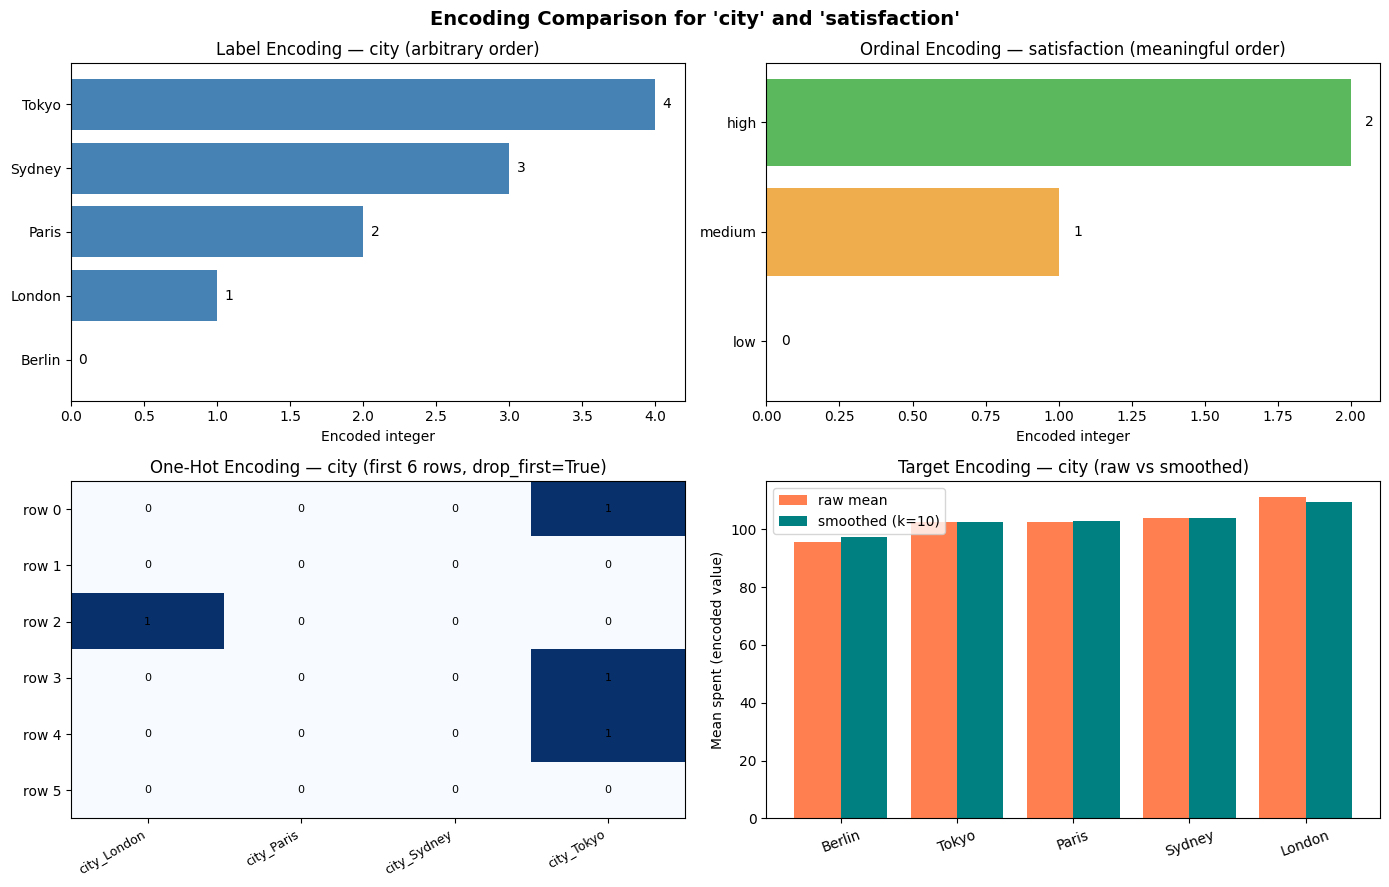

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(14, 9))
fig.suptitle("Encoding Comparison for 'city' and 'satisfaction'", fontsize=14, fontweight="bold")

# --- Label Encoding: city ---
ax = axes[0, 0]
label_vals = df[["city", "city_label"]].drop_duplicates().sort_values("city_label")
ax.barh(label_vals["city"], label_vals["city_label"], color="steelblue")
ax.set_xlabel("Encoded integer")
ax.set_title("Label Encoding — city (arbitrary order)")
for i, (v, c) in enumerate(zip(label_vals["city_label"], label_vals["city"])):
    ax.text(v + 0.05, i, str(v), va="center")

# --- Ordinal Encoding: satisfaction ---
ax = axes[0, 1]
ord_vals = df[["satisfaction", "satisfaction_ordinal"]].drop_duplicates().sort_values("satisfaction_ordinal")
colors = ["#d9534f", "#f0ad4e", "#5cb85c"]
ax.barh(ord_vals["satisfaction"], ord_vals["satisfaction_ordinal"], color=colors)
ax.set_xlabel("Encoded integer")
ax.set_title("Ordinal Encoding — satisfaction (meaningful order)")
for i, v in enumerate(ord_vals["satisfaction_ordinal"]):
    ax.text(v + 0.05, i, str(v), va="center")

# --- One-Hot: city ---
ax = axes[1, 0]
ohe_preview = city_dummies.head(6).copy()
im = ax.imshow(ohe_preview.values, aspect="auto", cmap="Blues", vmin=0, vmax=1)
ax.set_xticks(range(len(ohe_preview.columns)))
ax.set_xticklabels(ohe_preview.columns, rotation=30, ha="right", fontsize=9)
ax.set_yticks(range(len(ohe_preview)))
ax.set_yticklabels([f"row {i}" for i in range(len(ohe_preview))])
ax.set_title("One-Hot Encoding — city (first 6 rows, drop_first=True)")
for r in range(ohe_preview.shape[0]):
    for c in range(ohe_preview.shape[1]):
        ax.text(c, r, int(ohe_preview.iloc[r, c]), ha="center", va="center", fontsize=8)

# --- Target Encoding: city ---
ax = axes[1, 1]
tgt_vals = df[["city", "city_target_enc", "city_target_smoothed"]].drop_duplicates().sort_values("city_target_enc")
x = range(len(tgt_vals))
ax.bar([i - 0.2 for i in x], tgt_vals["city_target_enc"], width=0.4, label="raw mean", color="coral")
ax.bar([i + 0.2 for i in x], tgt_vals["city_target_smoothed"], width=0.4, label="smoothed (k=10)", color="teal")
ax.set_xticks(list(x))
ax.set_xticklabels(tgt_vals["city"], rotation=20)
ax.set_ylabel("Mean spent (encoded value)")
ax.set_title("Target Encoding — city (raw vs smoothed)")
ax.legend()

plt.tight_layout()
plt.savefig("encoding_comparison.png", dpi=120, bbox_inches="tight")
plt.show()

## 8. Final Encoded DataFrame

Below is the full feature matrix ready for model input. We select one encoded version per feature.

In [16]:
feature_cols = [
    "education_ordinal",       # ordinal — rank is meaningful
    "satisfaction_ordinal",    # ordinal — rank is meaningful
    "city_label",              # label — use with tree models only
    # or use city_Berlin, city_London, ... for linear models (OHE)
    # or use city_target_smoothed for high-cardinality / gradient boosting
    "spent"                    # target
]

model_df = df[feature_cols].copy()
print(f"Model-ready shape: {model_df.shape}")
model_df.head(10)

Model-ready shape: (200, 4)


,education_ordinal,satisfaction_ordinal,city_label,spent
0,1,2,4,112.25
1,3,2,0,139.41
2,2,0,1,85.96
3,1,0,4,80.76
4,0,0,4,72.54
5,0,0,0,51.11
6,0,0,1,74.43
7,2,1,0,99.30
8,1,0,1,44.45
9,2,1,3,119.17


## 9. Summary: Which Encoding to Use

| Feature type | Recommended encoding | Notes |
|---|---|---|
| Nominal, low cardinality | One-Hot Encoding | Use `drop='first'` with linear models |
| Nominal, high cardinality | Target Encoding (smoothed) | Always encode inside CV folds to prevent leakage |
| Nominal, tree-based model | Label Encoding | Trees handle arbitrary integers without issue |
| Ordinal (clear rank) | Ordinal Encoding | Define the category order explicitly |
| Target column (y) | Label Encoding | Standard for classification targets |

**Rules of thumb:**

- If a rank exists and matters, preserve it with Ordinal Encoding. Do not let the encoder guess the order.
- If no rank exists, do not use Label Encoding with linear or distance-based models — the arbitrary integers introduce a false ordering signal.
- Target Encoding is powerful but leaky. Always compute it on out-of-fold data during cross-validation.
- One-Hot Encoding is safe and interpretable but expensive for high-cardinality columns.